In [1]:
import camb
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import corner

In [66]:
#Gotta have that fall matplotlib aesthetic
c1 = 'xkcd:wine'
c2 = 'xkcd:dark yellow'
c3 = 'xkcd:olive green'

# a)

In [3]:
arr = np.genfromtxt('wmap_tt_spectrum_9yr_v5.txt')
l = arr[:,0]
C_l = arr[:,1]
err = arr[:,2]

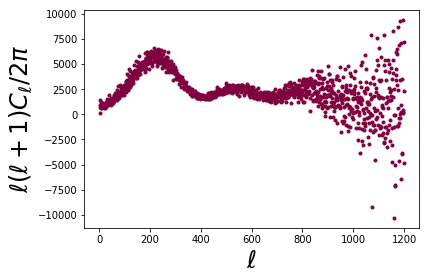

In [67]:
plt.plot(l,C_l,marker='.',ls='',c=c1)
plt.xlabel('$\ell$',fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$',fontsize=24)
plt.show()

In [5]:
cosmology = np.array([0.02256,0.1142,2.40e-9,0.9710,0.0851,69.7])
npars = len(cosmology)

In [6]:
pars = camb.CAMBparams()
pars.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],tau=cosmology[4],H0=cosmology[5])
pars.InitPower.set_params(As=cosmology[2],ns=cosmology[3])
pars.set_for_lmax(int(l.max()))
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [7]:
C_l_gen = powers['total'][int(l.min()):int(l.max()+1),0]

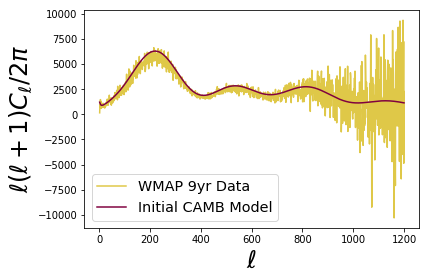

In [69]:
plt.plot(l,C_l,c=c2,alpha=0.75,label='WMAP 9yr Data')
plt.plot(l,C_l_gen,c=c1,label='Initial CAMB Model')
plt.xlabel('$\ell$',fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$',fontsize=24)
plt.legend(fontsize='x-large')
plt.show()

# b)

In [9]:
def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

In [10]:
def get_step(step_size=[1,1,1,1,1,1]):
    step_size = np.array(step_size)
    step = np.random.randn(len(step_size))*step_size
    return step

In [11]:
def get_spectrum(cosmology):
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],tau=cosmology[4],H0=cosmology[5])
    pars.InitPower.set_params(As=cosmology[2],ns=cosmology[3])
    pars.set_for_lmax(int(l.max()))
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    C_l_gen_new = powers['total'][int(l.min()):int(l.max()+1),0]
    return C_l_gen_new

In [12]:
def run_mcmc(data,err,init_cosmology,init_chisq,step_size,nstep,old_chain=None,
             save_fn=None,covariance=None):
    
    n_accepted = 0
    
    if old_chain is not None:
        chain = old_chain
        len_chain = len(old_chain)
        chain = np.append(chain,np.zeros((nstep,len(init_cosmology)+2)),axis=0)
        for i in range(len(init_cosmology)):
            init_cosmology[i] = chain[len_chain-1,i+2]
        model = get_spectrum(init_cosmology)
        init_chisq = get_chisq(data,model,err)
        print('Initial chisq: %.2f' %(init_chisq))
    else:
        chain = np.zeros((nstep,len(init_cosmology)+2))
        len_chain = 0
    
    for i in range(len_chain,len_chain+nstep):
        
        chain[i,0] = i+1
        print('On step %.0f' % (i+1))
        
        if covariance is None:
            step = get_step(step_size=step_size)
        else:
            step = simulate_corrnoise(covariance)
            step = step.T[0]
            
        new_cosmology = init_cosmology + step
        C_l_gen_new = get_spectrum(new_cosmology)
        new_chisq = get_chisq(data,C_l_gen_new,err)
        delchisq = new_chisq - init_chisq
        
        prob = np.exp(-0.5*delchisq)
        accept = np.random.rand() < prob
        #Need to give the prior that tau can't be negative
        accept = accept & (new_cosmology[4] > 0)
        
        if accept:
            print('Step accepted!')
            print('Delta chisq: %.2f' % (delchisq))
            print('Probability: %.2f \n' % (prob))
            
            n_accepted += 1
            init_cosmology = new_cosmology
            init_chisq = new_chisq
            
        chain[i,1] = init_chisq
        chain[i,2:len(init_cosmology)+2] = init_cosmology
        
        if save_fn is not None:
            np.save(save_fn,chain)
        
    print('Percentage of steps accepted: %.2f' % (n_accepted/nstep))
    return chain

I'll try and figure out a good stepsize for my parameters. My method is essentially starting with a 5% delta in the parameter value for a step size, and editing if I find the chain is rejecting/accepting too many steps.

In [13]:
steps = np.ones(npars)
chisq = get_chisq(C_l,C_l_gen,err)
names = ['$\Omega_b h^2$','$\Omega_c h^2$','$A_s$','$n_s$',r'$\tau$','$H_0$']

### Find trial step sizes for each parameter

In [14]:
def parabola(x,a,b,c):
    return a*x**2 + b*x + c

In [ ]:
approx_steps = np.zeros(npars)

for i in range(npars):
    
    step_size = [0,0,0,0,0,0]
    step_size[i] = 0.025*cosmology[i]
    nstep = 100
    chain_param = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep)
    param = chain_param[:,(i+2)]
    chisq_param = chain_param[:,1]
    step_num = chain_param[:,0]
    _,inds = np.unique(param,return_index=True)
    p = np.polyfit(param,chisq_param,2)
    x = np.linspace(param.min(),param.max(),100)
    
    plt.plot(x,parabola(x,*p),c=c2)
    plt.plot(param,chisq_param,marker='*',ls='',c=c1,markersize=10)
    plt.ylabel('$\chi^2$',fontsize=24)
    plt.xlabel(names[i],fontsize=24)
    plt.show()
    
    plt.plot(step_num,param,c=c1,ls='',marker='*',markersize=10)
    plt.xlabel('Step Number',fontsize=24)
    plt.ylabel(names[i],fontsize=24)
    plt.show()
    
    approx_steps[i] = 1/p[0]**0.5
    np.save(names[i],param)
    np.save('chisq_' + names[i],chisq_param)
    
np.save('approx_steps',approx_steps)

### Trial Chain Varying All Parameters!!

In [15]:
import time
import os

In [16]:
approx_steps = np.load('approx_steps.npy')

In [ ]:
step_size = approx_steps
fn = 'chain_save.npy'
nstep = 50

if os.path.exists(fn):
    chain_save = np.load(fn)
    up_to = int(chain_save[:,0].max())
    chain_save = chain_save[:up_to]
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep,old_chain=chain_save,save_fn=fn)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))
else:
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology,chisq,step_size,nstep)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))

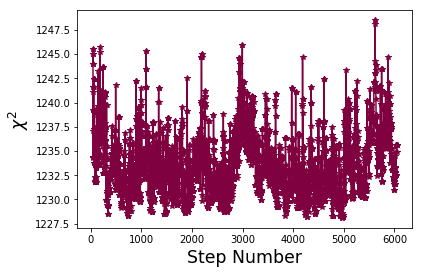

In [17]:
fn = 'chain_save.npy'
chain_trial = np.load(fn)
up_to = int(chain_trial[:,0].max())
chain_trial = chain_trial[:up_to]
start = 40
plt.plot(chain_trial[start:,0],chain_trial[start:,1],marker='*',c=c1)
plt.ylabel('$\chi^2$',fontsize='xx-large')
plt.xlabel('Step Number',fontsize='xx-large')
plt.show()

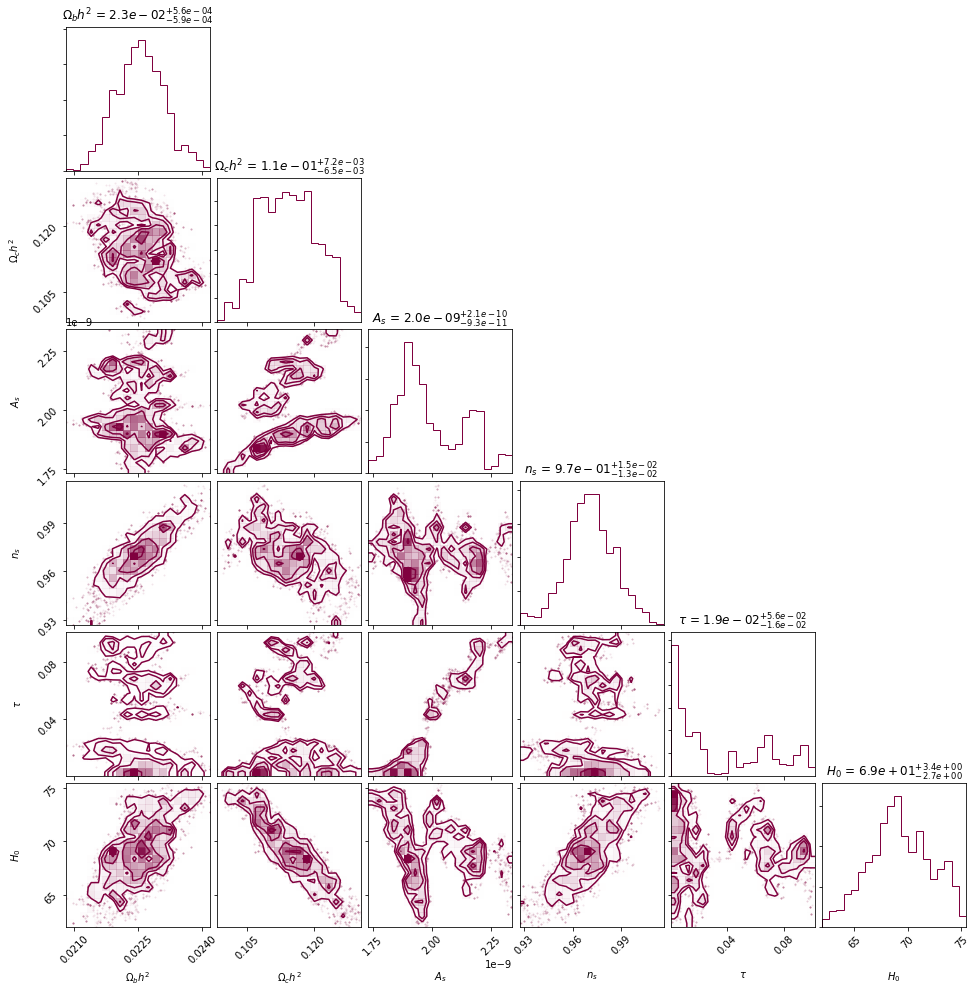

In [18]:
corner.corner(chain_trial[start:,2:],color=c1,max_n_ticks=3,labels=names,show_titles=True,
             title_fmt='.1e')
plt.show()

In [71]:
def analyse_chain(chain_trial):
    for i in range(2,chain_trial.shape[1]):
        
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(24,6))
        
        dat=chain_trial[:,i].copy()
        myval=np.mean(dat)
        mystd=np.std(dat)
        dat=dat-myval
        ax[0].plot(dat,c=c1)
        ax[0].set_ylabel('$\Delta$'+names[i-2],fontsize='x-large')
        ax[0].set_xlabel('Step Number',fontsize='x-large')
        
        datft=np.fft.rfft(dat)
        ps = np.abs(datft)**2
        ax[2].loglog(ps[1:],c=c3)
        
        mycorr=np.fft.irfft(datft*np.conj(datft))
        mylen=np.min(np.where(mycorr<0))
        nsamp=len(dat)/mylen
        ax[1].plot(mycorr[:int(len(mycorr)/2)],c=c2,lw=3)
        ax[1].axvline(mylen,c='k')
        ax[1].set_ylabel('Autocorrelation of '+names[i-2],fontsize='x-large')
        ax[1].set_xlabel('Step Number',fontsize='x-large')
        plt.show()
        print('Mean/Err on ' + names[i-2] + ' are: %.2e pm %.2e with roughly %.2f indepenent samples' % (myval,mystd/nsamp,nsamp))

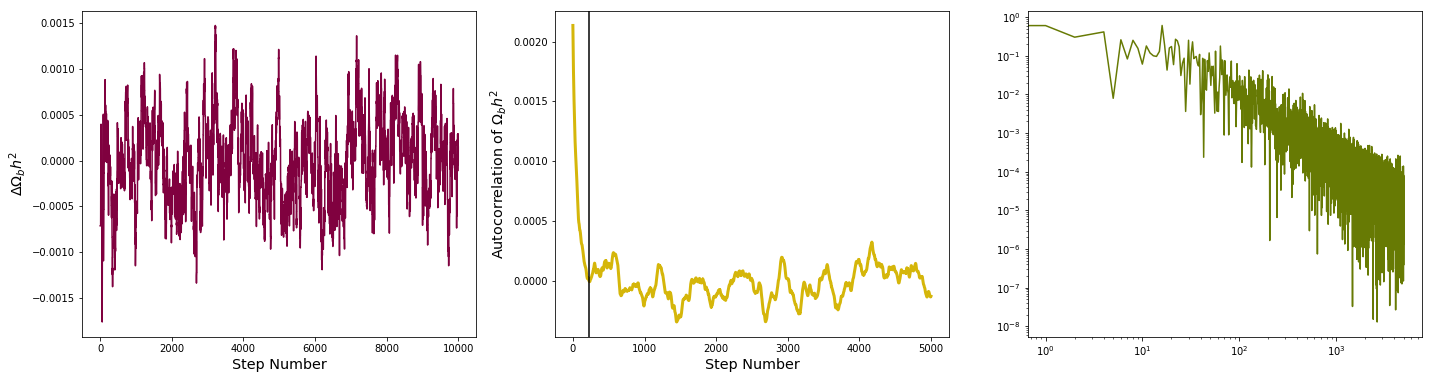

Mean/Err on $\Omega_b h^2$ are: 2.28e-02 pm 1.04e-05 with roughly 44.64 indepenent samples


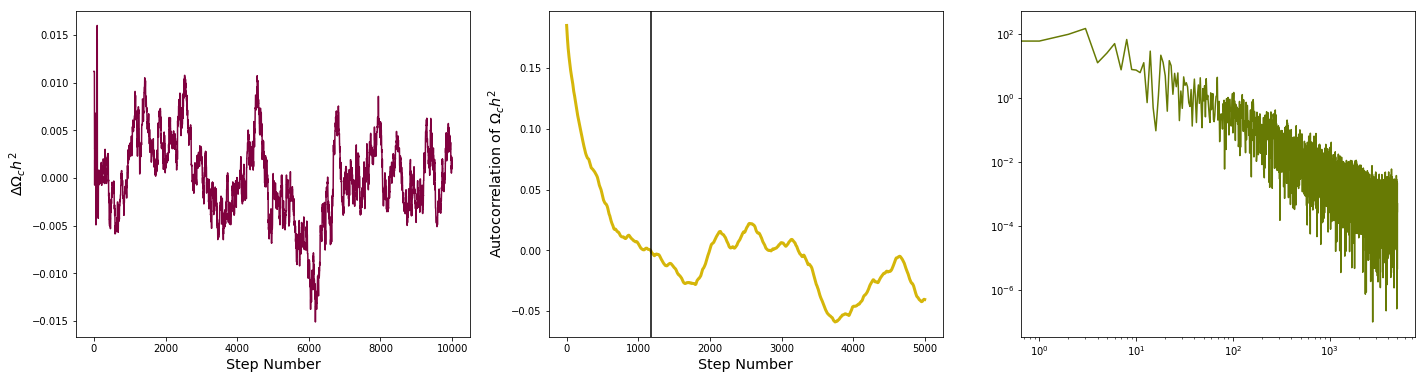

Mean/Err on $\Omega_c h^2$ are: 1.12e-01 pm 5.04e-04 with roughly 8.52 indepenent samples


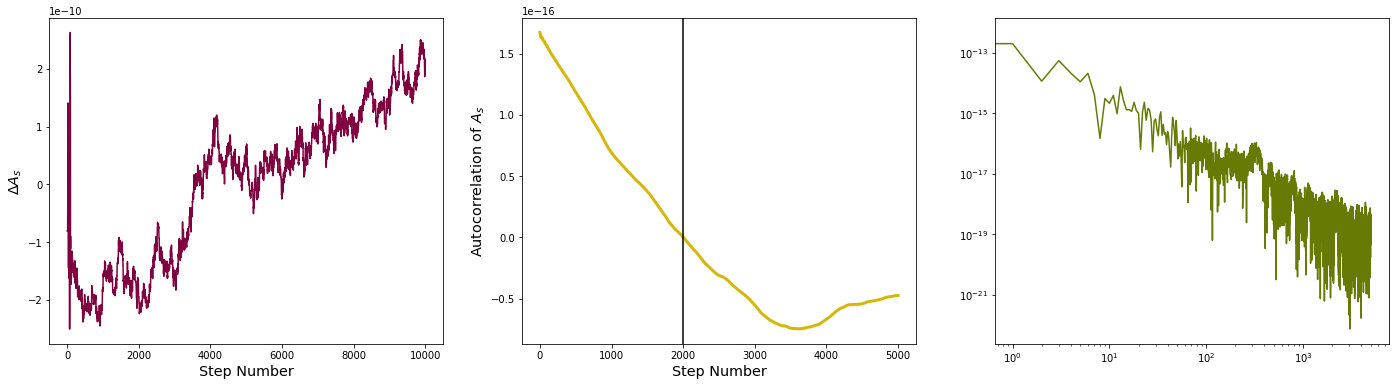

Mean/Err on $A_s$ are: 2.07e-09 pm 2.59e-11 with roughly 4.99 indepenent samples


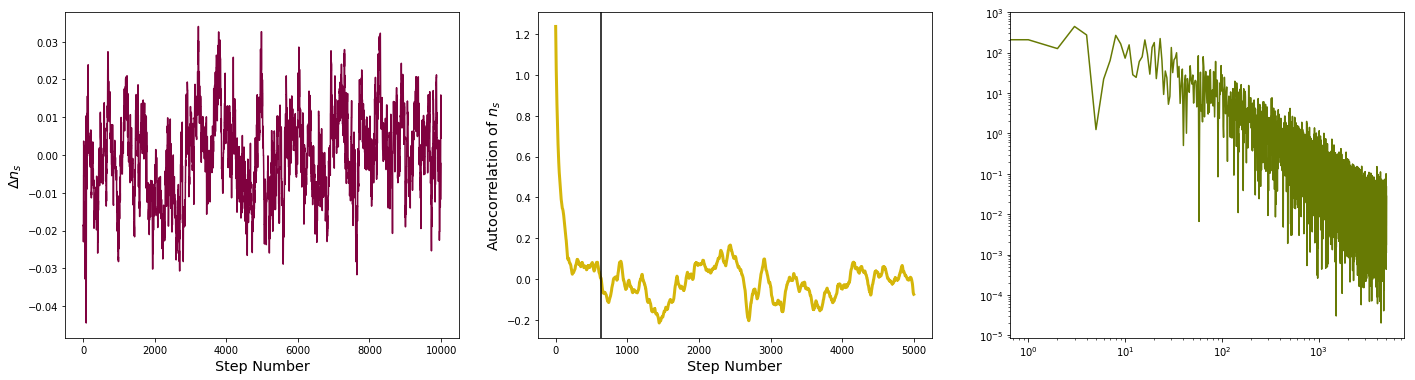

Mean/Err on $n_s$ are: 9.77e-01 pm 7.09e-04 with roughly 15.70 indepenent samples


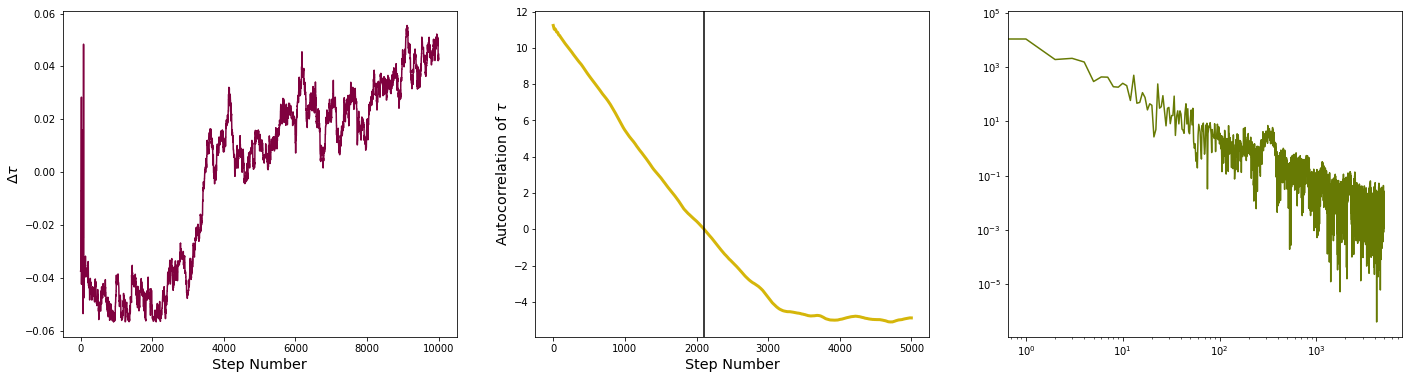

Mean/Err on $\tau$ are: 5.66e-02 pm 7.06e-03 with roughly 4.75 indepenent samples


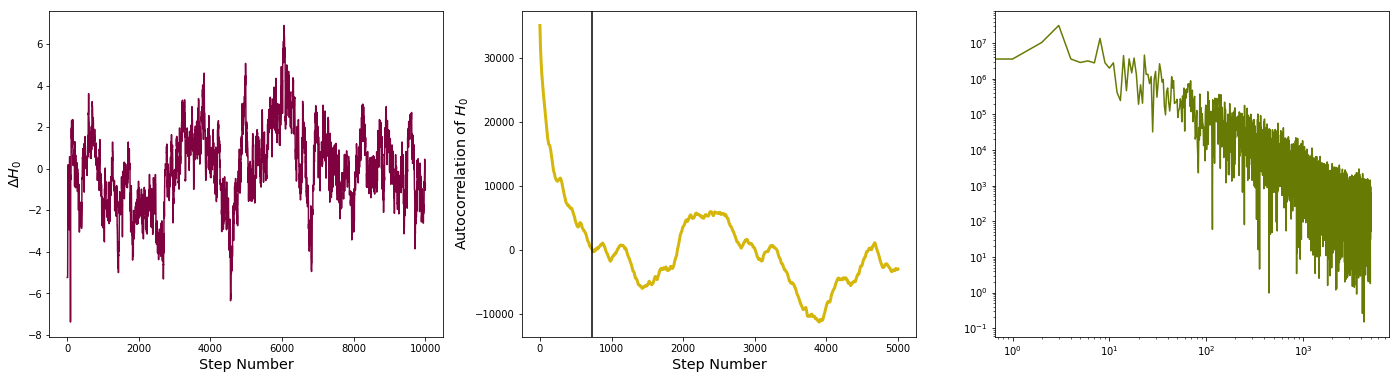

Mean/Err on $H_0$ are: 7.05e+01 pm 1.37e-01 with roughly 13.68 indepenent samples


In [72]:
analyse_chain(chain_trial)

In [27]:
def simulate_corrnoise(mat,nset=1):
    e,v=np.linalg.eigh(mat)
    e[e<0]=0 #make sure we don't have any negative eigenvalues due to roundoff
    n=len(e)
    #make gaussian random variables
    g=np.random.randn(n,nset)
    #now scale them by the square root of the eigenvalues
    rte=np.sqrt(e)
    for i in range(nset):
        g[:,i]=g[:,i]*rte
    #and rotate back into the original space
    dat=np.dot(v,g)
    return dat

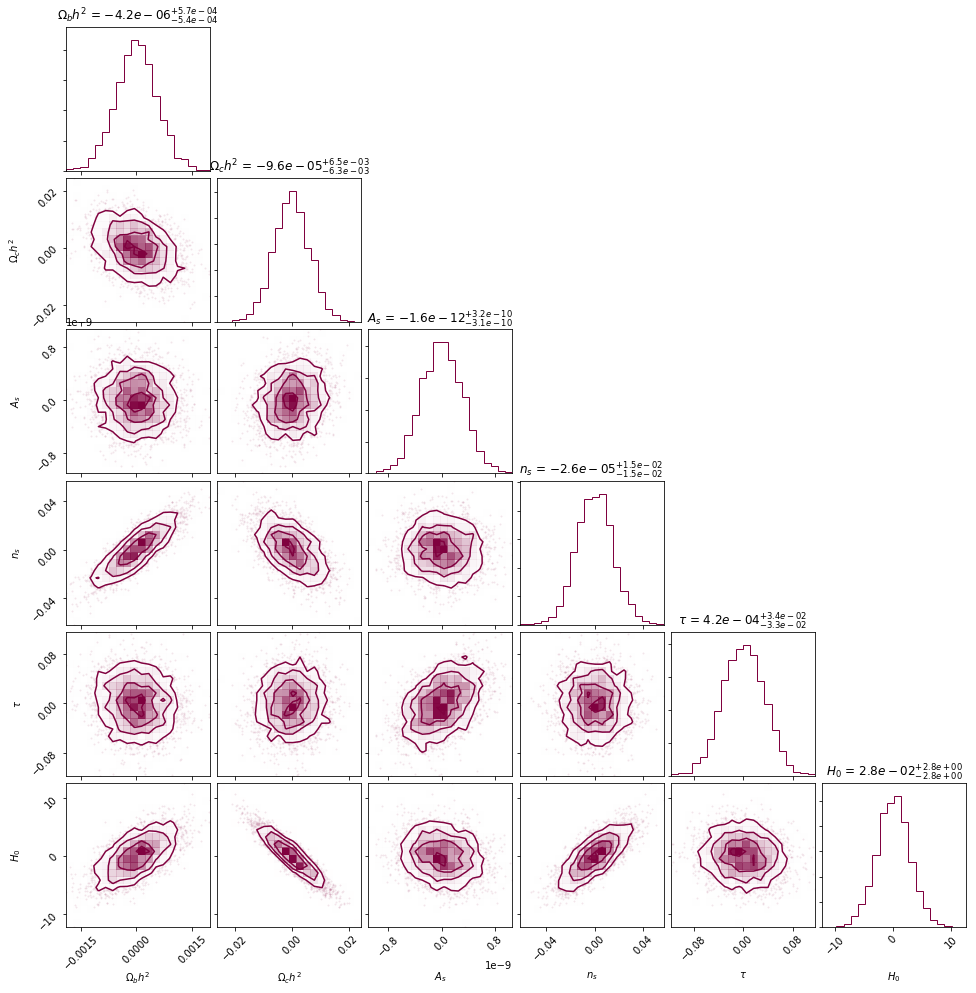

In [28]:
cov = np.cov(chain_trial[:,2:].T)
test = simulate_corrnoise(cov,nset=3000)
corner.corner(test.T,color=c1,max_n_ticks=3,labels=names,show_titles=True,
             title_fmt='.1e')
plt.show()

### Covariant Step Chain

In [ ]:
fn = 'chain_cov_save.npy'
nstep = 9900

if os.path.exists(fn):
    chain_save = np.load(fn)
    up_to = int(chain_save[:,0].max())
    chain_save = chain_save[:up_to]
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep,
                           old_chain=chain_save,save_fn=fn)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))
else:
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep,
                           save_fn=fn,covariance=cov)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))

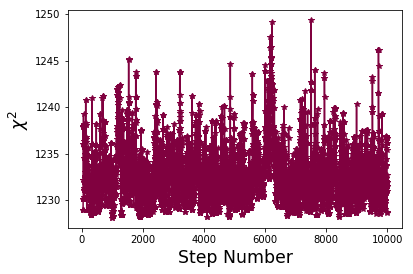

In [73]:
fn = 'chain_cov_save.npy'
chain_trial = np.load(fn)
up_to = int(chain_trial[:,0].max())
chain_trial = chain_trial[:up_to]
start = 40
plt.plot(chain_trial[start:,0],chain_trial[start:,1],marker='*',c=c1)
plt.ylabel('$\chi^2$',fontsize='xx-large')
plt.xlabel('Step Number',fontsize='xx-large')
plt.show()

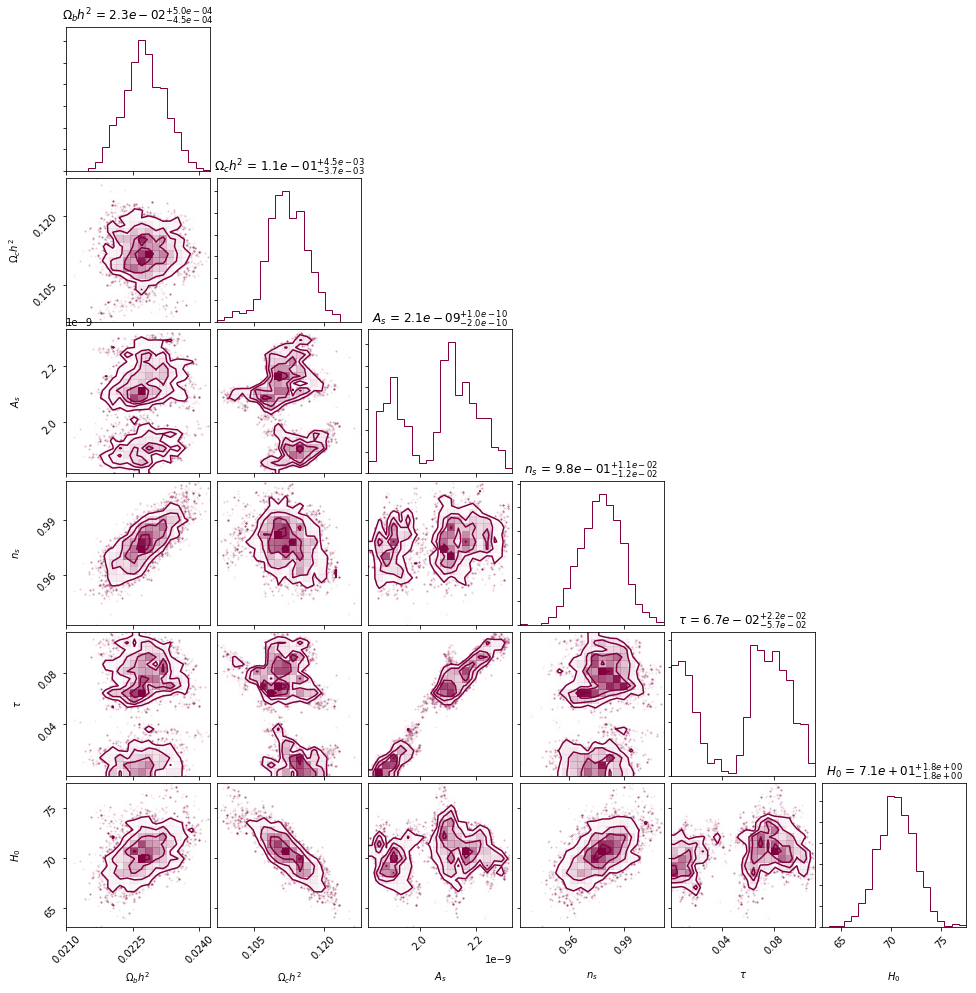

In [74]:
corner.corner(chain_trial[:,2:],color=c1,max_n_ticks=3,labels=names,show_titles=True,
              title_fmt='.1e')
plt.show()

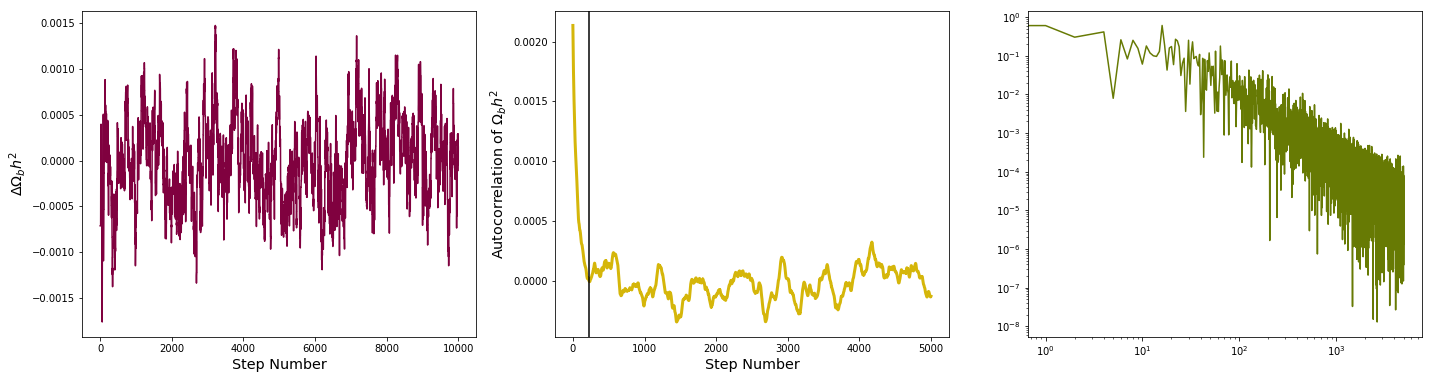

Mean/Err on $\Omega_b h^2$ are: 2.28e-02 pm 1.04e-05 with roughly 44.64 indepenent samples


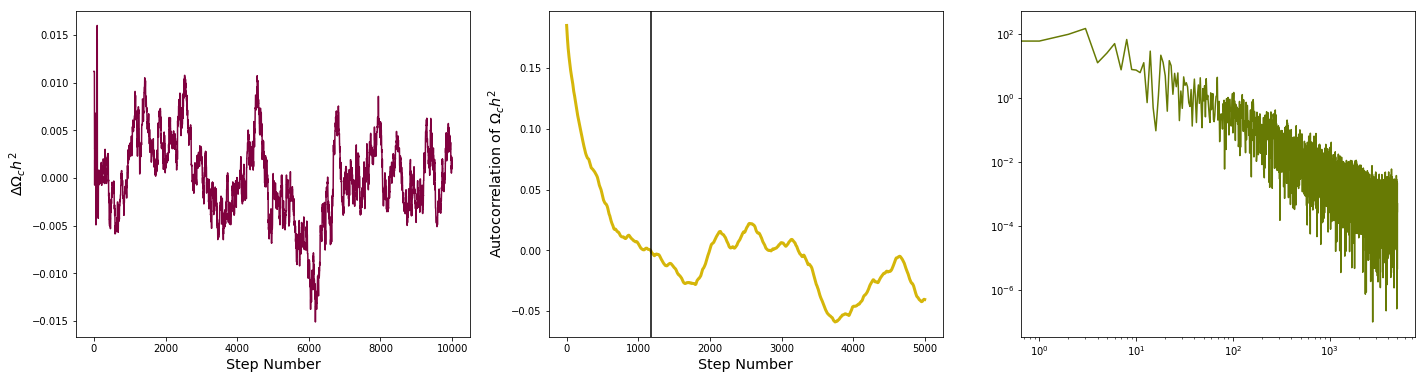

Mean/Err on $\Omega_c h^2$ are: 1.12e-01 pm 5.04e-04 with roughly 8.52 indepenent samples


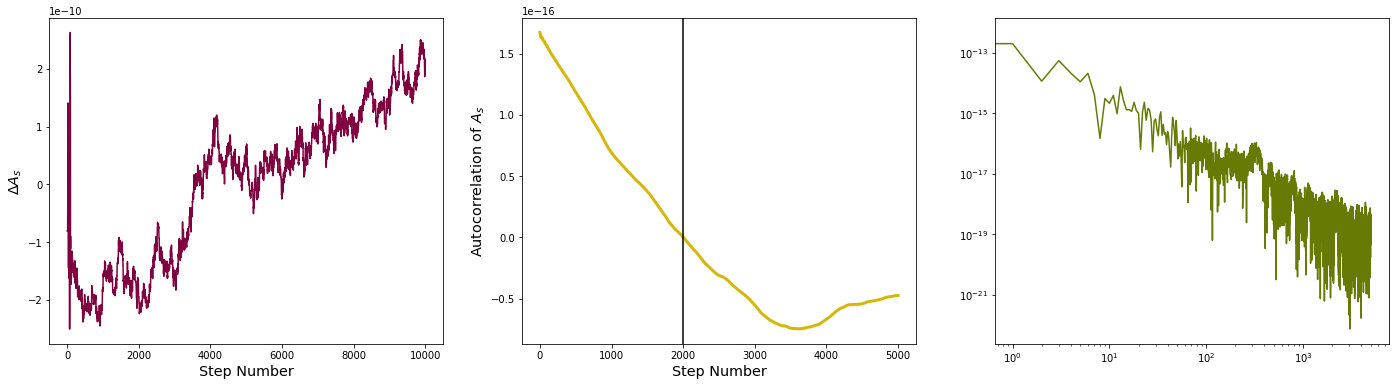

Mean/Err on $A_s$ are: 2.07e-09 pm 2.59e-11 with roughly 4.99 indepenent samples


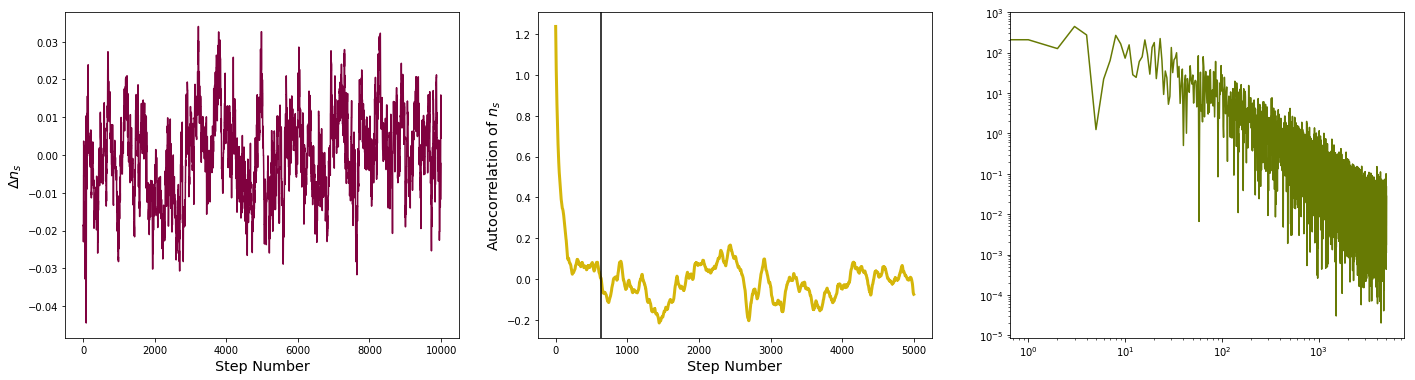

Mean/Err on $n_s$ are: 9.77e-01 pm 7.09e-04 with roughly 15.70 indepenent samples


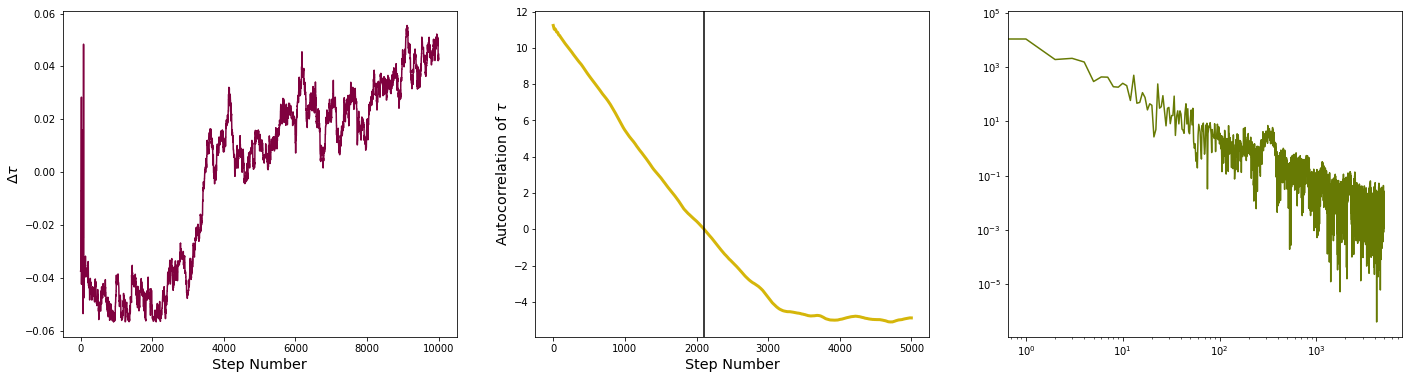

Mean/Err on $\tau$ are: 5.66e-02 pm 7.06e-03 with roughly 4.75 indepenent samples


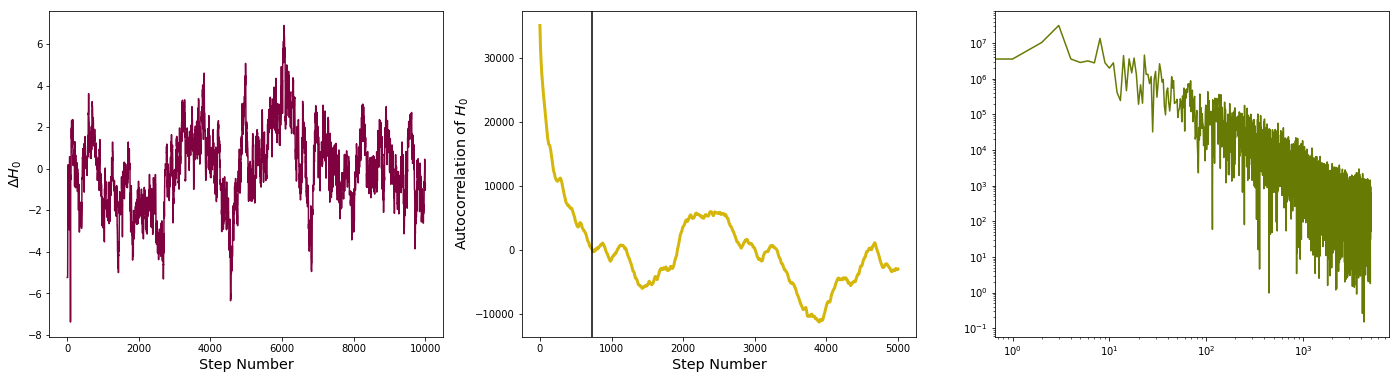

Mean/Err on $H_0$ are: 7.05e+01 pm 1.37e-01 with roughly 13.68 indepenent samples


In [75]:
analyse_chain(chain_trial)

Doesn't look great... I got a bimodal $A_s$ and $\tau$, so I should try making a new (better!) covariance matrix and do another big chain.

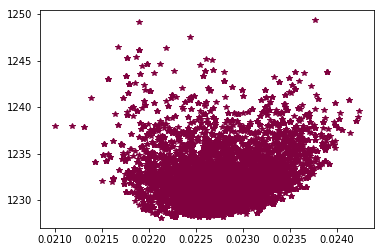

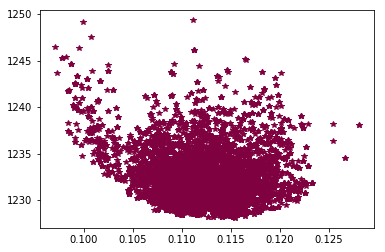

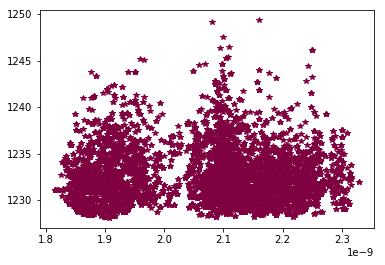

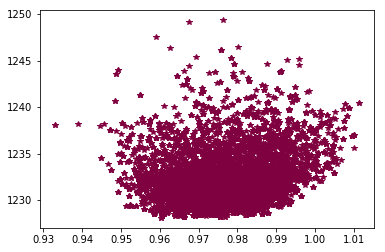

In [36]:
for i in range(2,npars):
    plt.plot(chain_trial[:,i],chain_trial[:,1],ls='',marker='*',c=c1)
    plt.show()

In [ ]:
cov = np.cov(chain_trial[:,2:].T)
test = simulate_corrnoise(cov,nset=3000)
corner.corner(test.T,color=c1,max_n_ticks=3,labels=names,show_titles=True,
             title_fmt='.1e')
plt.show()

For some reason this didn't correlate $A_s$ and $\tau$ very strongly...

In [ ]:
fn = 'chain_cov_save_2.npy'
nstep = 10000

if os.path.exists(fn):
    chain_save = np.load(fn)
    up_to = int(chain_save[:,0].max())
    chain_save = chain_save[:up_to]
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep,
                           old_chain=chain_save,save_fn=fn,covariance=cov)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))
else:
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep,
                           save_fn=fn,covariance=cov)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))

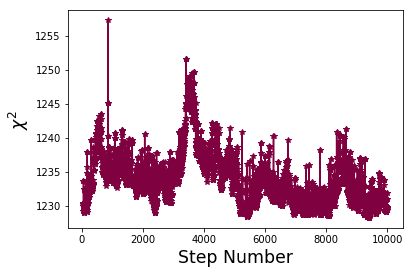

In [76]:
fn = 'chain_cov_save_2.npy'
chain_trial = np.load(fn)
up_to = int(chain_trial[:,0].max())
chain_trial = chain_trial[:up_to]
start = 40
plt.plot(chain_trial[start:,0],chain_trial[start:,1],marker='*',c=c1)
plt.ylabel('$\chi^2$',fontsize='xx-large')
plt.xlabel('Step Number',fontsize='xx-large')
plt.show()

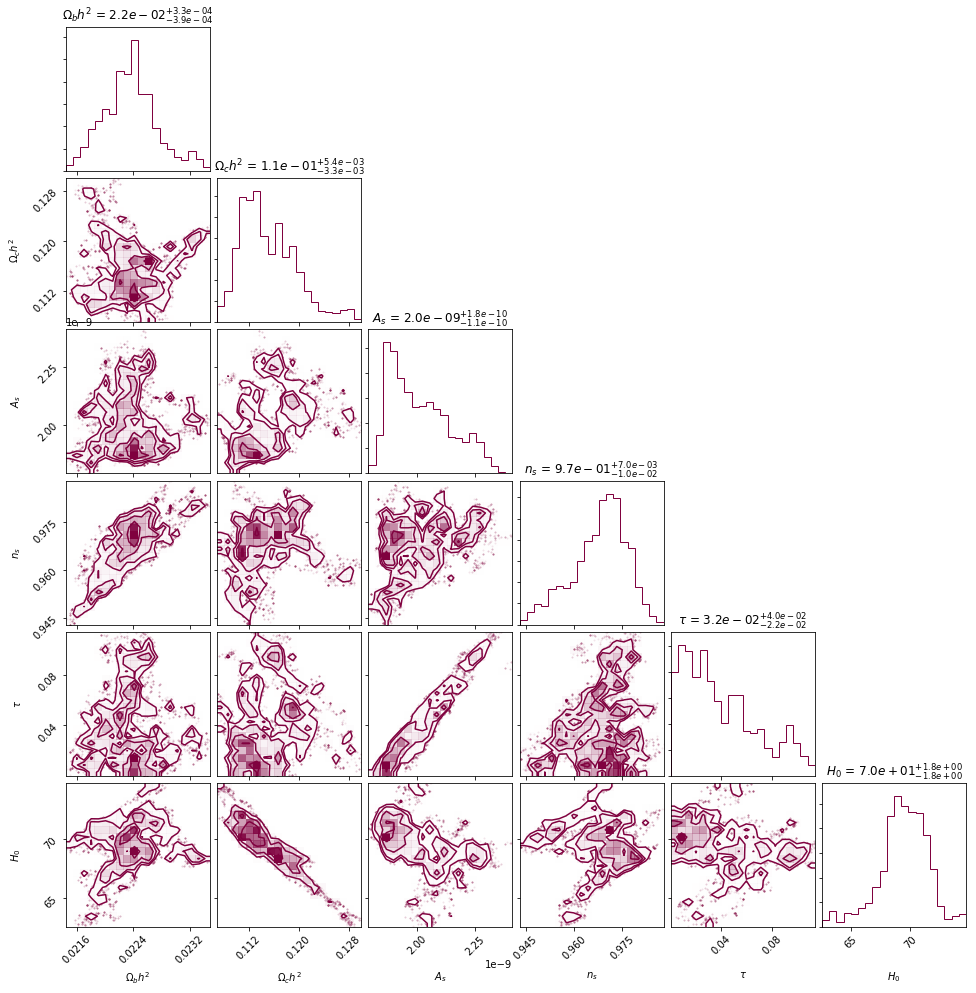

In [79]:
corner.corner(chain_trial[:,2:],color=c1,max_n_ticks=3,labels=names,show_titles=True,
              title_fmt='.1e')
plt.show()

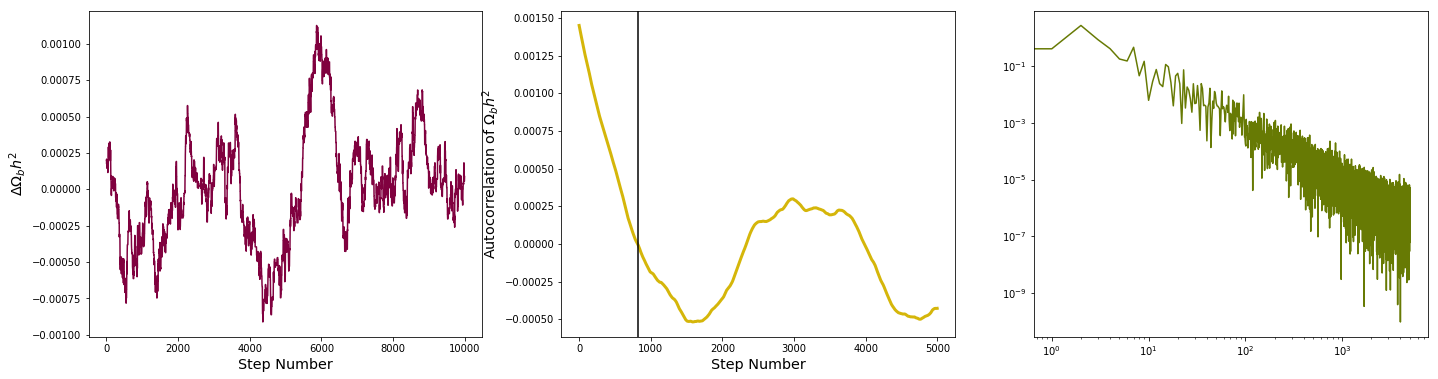

Mean/Err on $\Omega_b h^2$ are: 2.24e-02 pm 3.11e-05 with roughly 12.24 indepenent samples


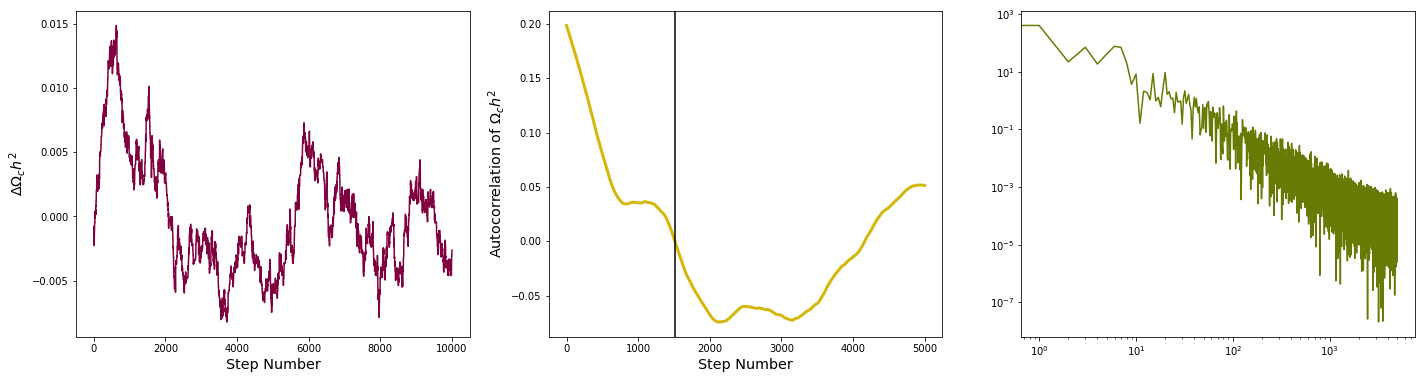

Mean/Err on $\Omega_c h^2$ are: 1.15e-01 pm 6.75e-04 with roughly 6.61 indepenent samples


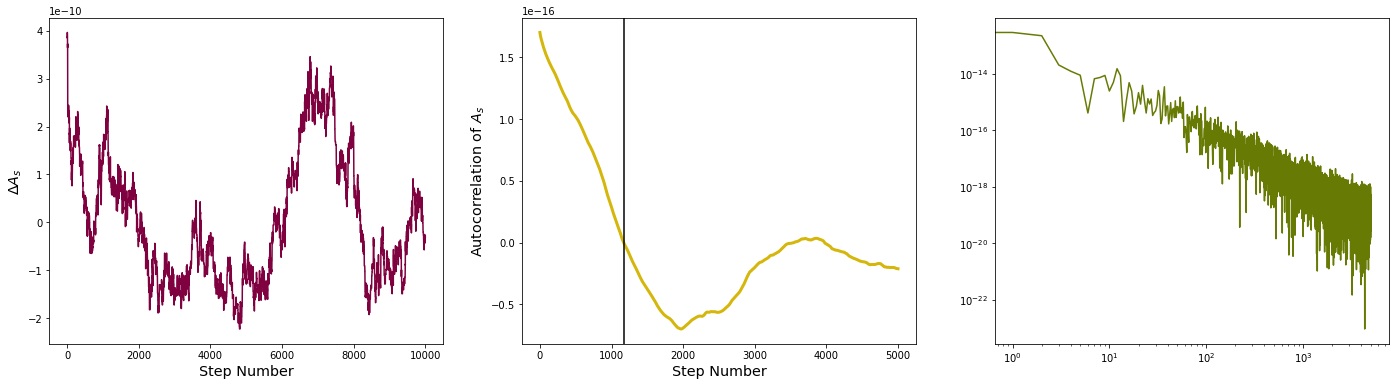

Mean/Err on $A_s$ are: 2.01e-09 pm 1.53e-11 with roughly 8.55 indepenent samples


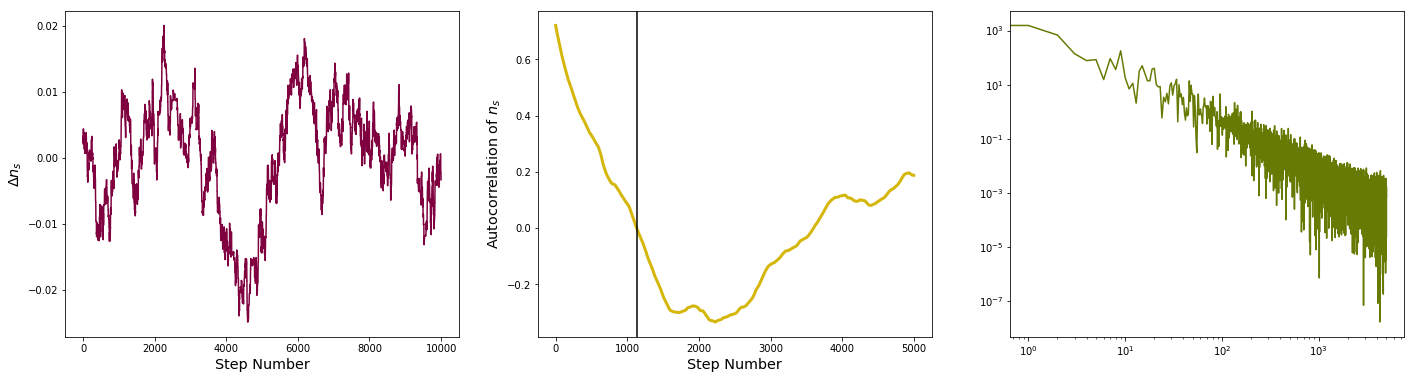

Mean/Err on $n_s$ are: 9.68e-01 pm 9.61e-04 with roughly 8.83 indepenent samples


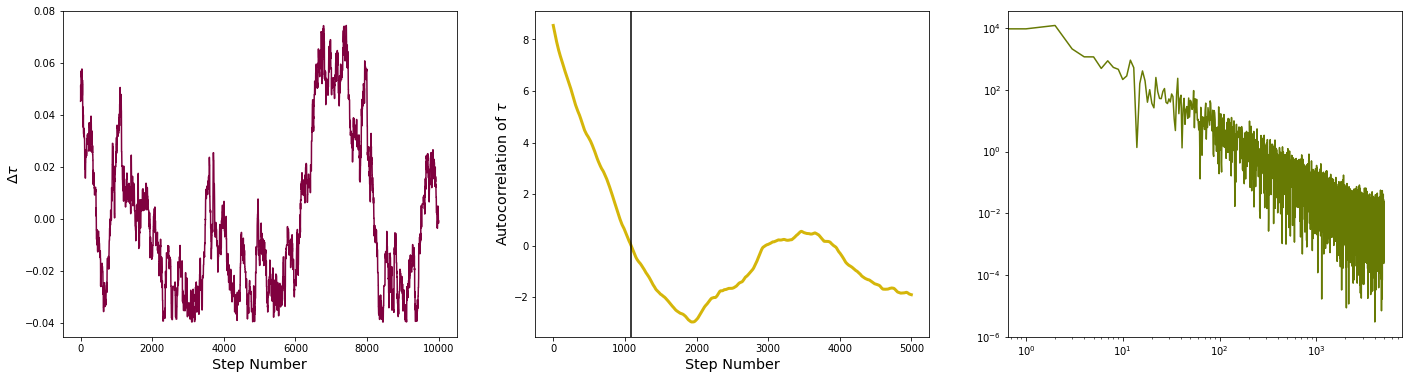

Mean/Err on $\tau$ are: 3.98e-02 pm 3.18e-03 with roughly 9.19 indepenent samples


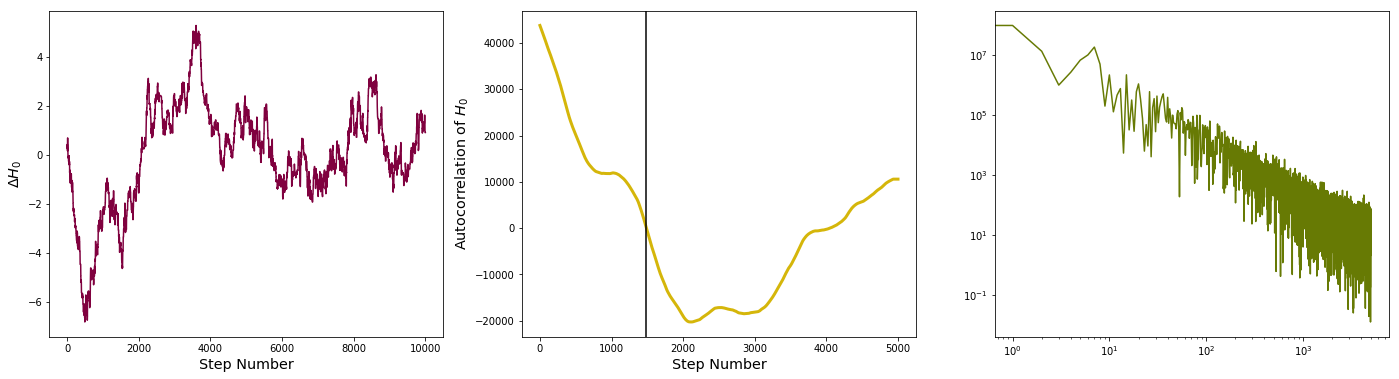

Mean/Err on $H_0$ are: 6.94e+01 pm 3.11e-01 with roughly 6.72 indepenent samples


In [77]:
analyse_chain(chain_trial)

Looks like a mess.